In [2]:
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers
normalize = True
expert_rule = True

2023-02-17 16:11:12.794876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 16:11:12.794907: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df,df_left_out = leave_one_out()
X_train = df.drop('label',axis=1)
y_train = df['label']
X_test = df_left_out.drop('label',axis=1)
y_test = df_left_out['label']
y_test = pd.Categorical(y_test).codes
y_train = pd.Categorical(y_train).codes

In [4]:
if normalize:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [5]:
model = keras.Sequential()
model.add(layers.Dense(512, activation="relu", input_shape=(X_train.shape[-1],)))
model.add(layers.Dense(3, activation="softmax"))

2023-02-17 16:11:19.156195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 16:11:19.156586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 16:11:19.156652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-17 16:11:19.156697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-17 16:11:19.156751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy()
    )
model.fit(X_train,tf.one_hot(y_train,3),epochs=3)

Epoch 1/3
8368/8368 [==============================] - 5s 609us/step - loss: 0.4041
Epoch 2/3
8368/8368 [==============================] - 5s 611us/step - loss: 0.3739
Epoch 3/3
8368/8368 [==============================] - 5s 637us/step - loss: 0.3649


270/270 [==============================] - 0s 353us/step
precision:  0.8633202347587732
recall:  0.8831071239551438
f1:  0.8724589789072201


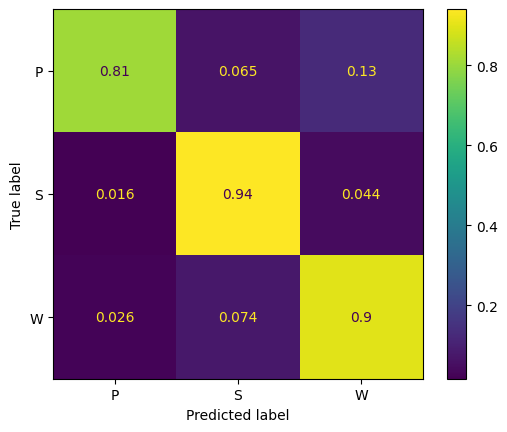

In [7]:
y_pred = np.argmax(model.predict(X_test),axis=1)
if expert_rule:
    for i in range(len(y_pred)-2):
        if y_pred[i] == y_pred[i+2]:
            y_pred[i+1] = y_pred[i]
        if (y_pred[i:i+3] == [1,2,0]).all():
            y_pred[i+1] = 0
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='true'),display_labels=['P','S','W'])
cm.plot()
precision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
print('precision: ',precision)
print('recall: ',recall)
print('f1: ',f1)

In [40]:
df = pd.read_excel(f'386-KO-22 24hr.xls')
df = df.drop(0)
df
for x,y in zip(df.columns[1:-2],np.linspace(0,19.5,40)):
    df = df.rename(mapper = {x:str(y)},axis=1)
df = df.rename(mapper = {'EEG 1 (Mean, 10s)':'emg'},axis=1)
df = df.rename(mapper = {'Activity (Mean, 10s)':'activity'},axis=1)
df = df.rename(mapper = {'Rodent Sleep':'label'},axis=1)

df = df[df['label']!='X']
df = df.drop('0.0',axis=1)
X_test = df.drop('label',axis=1).to_numpy()
X_test = scaler.transform(X_test)

WARNING *** file size (6907005) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


/home/andrew/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



270/270 [==============================] - 0s 340us/step
precision:  0.901578904060608
recall:  0.7191001553125527
f1:  0.753699610248018


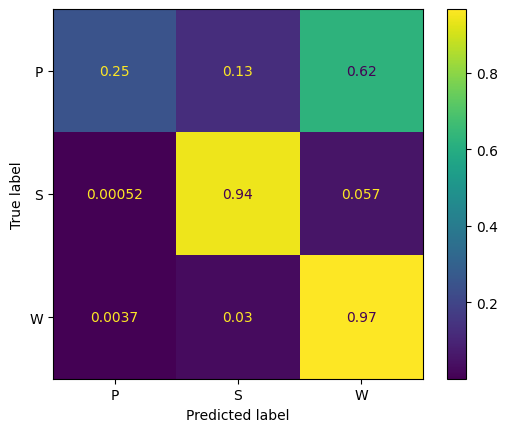

In [41]:

y_test = df['label']
y_test = pd.Categorical(y_test).codes

y_pred = np.argmax(model.predict(X_test),axis=1)
if expert_rule:
    for i in range(len(y_pred)-2):
        if y_pred[i] == y_pred[i+2]:
            y_pred[i+1] = y_pred[i]
        if (y_pred[i:i+3] == [1,2,0]).all():
            y_pred[i+1] = 0
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='true'),display_labels=['P','S','W'])
cm.plot()
precision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
print('precision: ',precision)
print('recall: ',recall)
print('f1: ',f1)

In [42]:
import plotly.express as px
fig = px.line(pd.DataFrame([y_test,y_pred]).T)
fig.show(renderer='browser')